## RGS14 Sleep state transition research based on aperiodic signal 
### Part 1: Process data

In [271]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal, io
from fooof import FOOOF
import pingouin as pg
import seaborn as sns
import glob
import re
import os
import math
import scipy.io as sio
from collections import Counter
from scipy.stats import (
    f_oneway,          
    levene,              
    sem   
)

### 1.1 Load in all data
- Data is stored locally 
- Folders for each condition HomeCageHC / OverlappingOR /...
- Each condition contains folder Rat1 till Rat9
- Each rat folder contains `HPC_100.continuous.mat`, `PFC_100.continuous.mat`, `states.mat`


In [272]:


BASE_DATA_DIR = "./data"
CONDITIONS_DIR_NAMES = ['HomeCageHC', "OverlappingOR", "RandomCon", "StableCondOD"]
CONTROL_RATS = [1, 2, 6, 9]
RGS_RATS = [3, 4, 7, 8]
EPISODE_STATES  = [1, 3, 5]                   

STATE_MAP = {
    1: 'Wake',
    3: 'NREM',
    4: 'Inter',
    5: 'REM'
}

ALL_RATS = CONTROL_RATS + RGS_RATS

# Extratcs the trial number from the folder name so I dont have to manually chnage the file names
def extract_trial_number(folder_name):
    match = re.search(r'Post[-_]Trial(\d+)', folder_name, re.IGNORECASE)
    if match:
        return int(match.group(1))
    return None

def find_post_trial_folders(rat_dir):
    if not os.path.exists(rat_dir):
        return []
    
    post_trial_folders = []
    for item in os.listdir(rat_dir):
        item_path = os.path.join(rat_dir, item)
        if os.path.isdir(item_path):
            trial_num = extract_trial_number(item)
            if trial_num is not None:
                post_trial_folders.append((item, trial_num))
    
    post_trial_folders.sort(key=lambda x: x[1])
    return post_trial_folders

def find_data_file(folder_path, file_type):
    if file_type == 'states':
        patterns = ['*states.mat', '*-states.mat']
    elif file_type == 'hpc':
        patterns = ['HPC_cleaned.mat', 'HPC_*.continuous.mat', '*HPC*.mat']
    elif file_type == 'pfc':
        patterns = ['PFC_cleaned.mat', 'PFC_*.continuous.mat', '*PFC*.mat']
    else:
        return None
    for pattern in patterns:
        matches = glob.glob(os.path.join(folder_path, pattern))
        if matches:
            return matches[0]  # Return first match
    
    return None

def load_rat_data(folder_path, rat_index, trial_number):

    print(f'  Loading Trial {trial_number} from: {folder_path}')
    states_file = find_data_file(folder_path, 'states')
    hpc_file = find_data_file(folder_path, 'hpc')
    pfc_file = find_data_file(folder_path, 'pfc')
    
    if not all([states_file, hpc_file, pfc_file]):
        print(f'    Warning: Missing files in {folder_path}')
        print(f'    States: {states_file}')
        print(f'    HPC: {hpc_file}')
        print(f'    PFC: {pfc_file}')
        return None
    
    try:
        states_mat = io.loadmat(states_file)
        hpc_mat = io.loadmat(hpc_file)
        pfc_mat = io.loadmat(pfc_file)
        
        states_data = None
        hpc_data = None
        pfc_data = None
        

        for key in states_mat.keys():
            if not key.startswith('__') and 'states' in key.lower():
                states_data = states_mat[key].ravel()
                break
        

        for key in hpc_mat.keys():
            if not key.startswith('__'):
                hpc_data = hpc_mat[key].ravel()
                break
        
        for key in pfc_mat.keys():
            if not key.startswith('__'):
                pfc_data = pfc_mat[key].ravel()
                break
        
        if states_data is None or hpc_data is None or pfc_data is None:
            print(f'    Warning: Could not extract data from mat files in {folder_path}')
            return None
        
        data_object = {
            'number': rat_index,
            'trial': trial_number,
            'states': states_data,
            'hpc': hpc_data,
            'pfc': pfc_data,
        }
        
        print(f'    Successfully loaded Trial {trial_number} - States: {len(states_data)}, HPC: {len(hpc_data)}, PFC: {len(pfc_data)}')
        return data_object
        
    except Exception as e:
        print(f'    Error loading data from {folder_path}: {str(e)}')
        return None


rats_data = {
    condition: {
        'rgs_positive': [],
        'rgs_negative': []
    }
    for condition in CONDITIONS_DIR_NAMES
}



In [273]:
for condition in CONDITIONS_DIR_NAMES:
    print(f'\nProcessing condition: {condition}')
        
        # Process CONTROL_RATS (rgs_negative)
    for rat_index in CONTROL_RATS:
        rat_dir = f"{BASE_DATA_DIR}/{condition}/Rat{rat_index}"
        print(f'Processing Rat{rat_index} (Control)')
        

        post_trial_folders = find_post_trial_folders(rat_dir)
        
        if not post_trial_folders:
            print(f'  No post-trial folders found for Rat{rat_index}')
            continue
        

        for folder_name, trial_number in post_trial_folders:
            folder_path = os.path.join(rat_dir, folder_name)
            data_object = load_rat_data(folder_path, rat_index, trial_number)
            
            if data_object is not None:
                rats_data[condition]['rgs_negative'].append(data_object)
    

    for rat_index in RGS_RATS:
        rat_dir = f"{BASE_DATA_DIR}/{condition}/Rat{rat_index}"
        print(f'Processing Rat{rat_index} (RGS)')
        

        post_trial_folders = find_post_trial_folders(rat_dir)
        
        if not post_trial_folders:
            print(f'  No post-trial folders found for Rat{rat_index}')
            continue
        

        for folder_name, trial_number in post_trial_folders:
            folder_path = os.path.join(rat_dir, folder_name)
            data_object = load_rat_data(folder_path, rat_index, trial_number)
            
            if data_object is not None:
                rats_data[condition]['rgs_positive'].append(data_object)



print(f'Successfully loaded data for conditions: {CONDITIONS_DIR_NAMES}')


Processing condition: HomeCageHC
Processing Rat1 (Control)
  Loading Trial 1 from: ./data/HomeCageHC/Rat1/2018-08-01_11-21-14_Post-Trial1
    Successfully loaded Trial 1 - States: 2700, HPC: 2700698, PFC: 2700698
  Loading Trial 2 from: ./data/HomeCageHC/Rat1/2018-08-01_12-11-44_Post-Trial2
    Successfully loaded Trial 2 - States: 2700, HPC: 2700664, PFC: 2700664
  Loading Trial 3 from: ./data/HomeCageHC/Rat1/2018-08-01_13-02-00_Post-Trial3
    Successfully loaded Trial 3 - States: 2700, HPC: 2700937, PFC: 2700937
  Loading Trial 4 from: ./data/HomeCageHC/Rat1/2018-08-01_13-53-50_Post-Trial4
    Successfully loaded Trial 4 - States: 2752, HPC: 2753298, PFC: 2753298
  Loading Trial 5 from: ./data/HomeCageHC/Rat1/Post-Trial5
    Successfully loaded Trial 5 - States: 10758, HPC: 10760978, PFC: 10760978
Processing Rat2 (Control)
  Loading Trial 1 from: ./data/HomeCageHC/Rat2/2018-07-30_12-15-16_Post-Trial1
    Successfully loaded Trial 1 - States: 2701, HPC: 2702268, PFC: 2702268
  Loadi

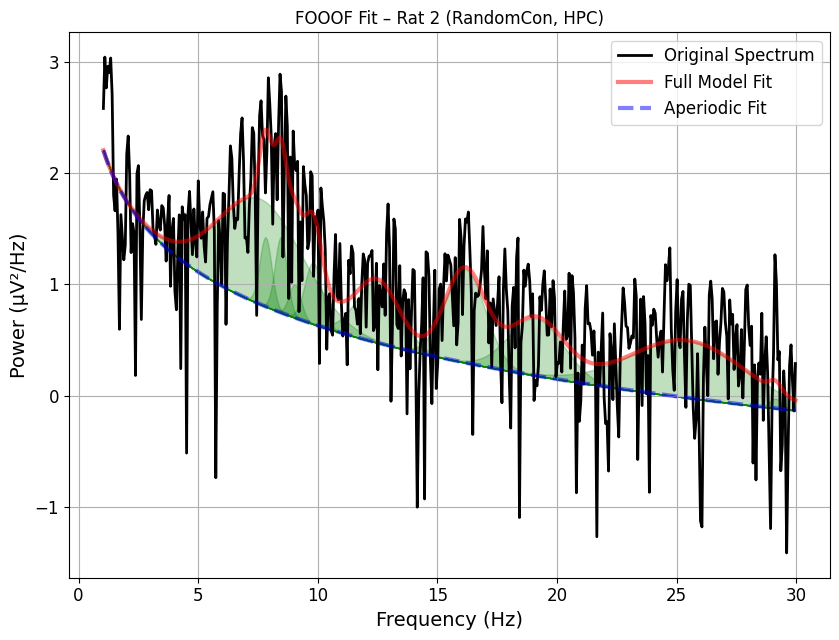

In [275]:

REGION = "HPC"  #
SAMPLE_FREQ = 1000
ADC_SCALE = 0.195
WINDOW_SEC = 15
FREQ_RANGE = (1, 30)


condition = "RandomCon"
rat_number = 2 
folder = f"{BASE_DATA_DIR}/{condition}/Rat{rat_number}/Post-Trial5"


hpc_data = io.loadmat(os.path.join(folder, "HPC_cleaned.mat"))["HPC_cleaned"].ravel()
eeg = hpc_data.astype(np.float64) * ADC_SCALE  # convert to µV


n_samples = SAMPLE_FREQ * WINDOW_SEC
start_idx = 50000  
eeg_segment = eeg[start_idx : start_idx + n_samples]

nfft = 1 << (n_samples - 1).bit_length()
f, Pxx = signal.welch(
    eeg_segment, fs=SAMPLE_FREQ, window='hamming',
    nperseg=n_samples, noverlap=n_samples // 2, nfft=nfft,
    scaling='density'
)


fm = FOOOF(aperiodic_mode='fixed', verbose=False)
fm.fit(f, Pxx, FREQ_RANGE)

# --- Plot ---
fm.plot(plot_peaks='shade', add_legend=True)
plt.title(f"FOOOF Fit – Rat {rat_number} ({condition}, {REGION})")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (μV²/Hz)")
plt.tight_layout()
plt.show()


### 1.2 Analysing all state transition and frequency

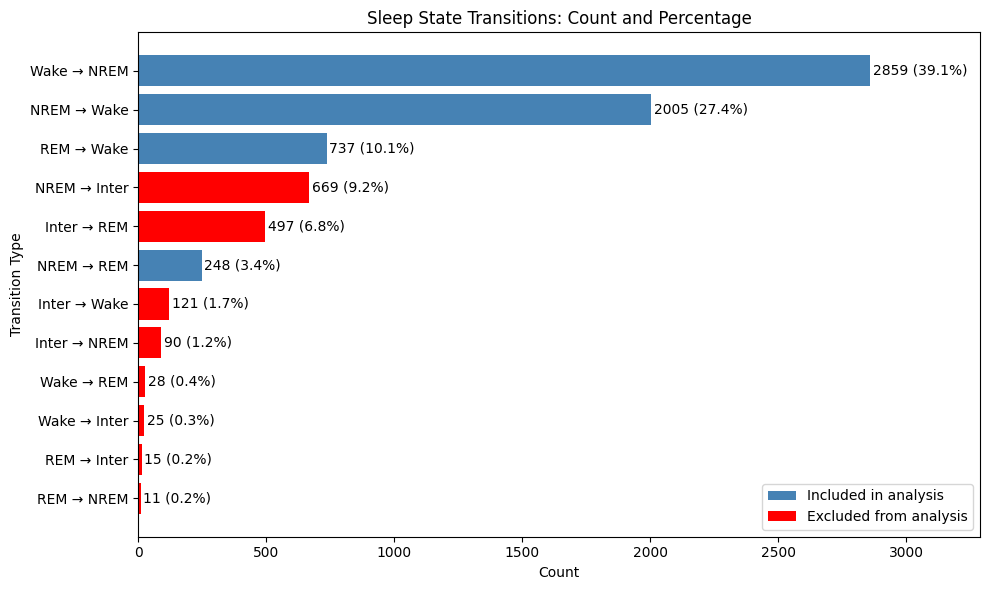

In [276]:
USED_TRANSITIONS = {
    (1, 3),  # Wake → NREM
    (3, 5),  # NREM → REM
    (5, 1),  # REM → Wake
    (3, 1),  # NREM → Wake (added justification)
}

def is_unknown(state):
    return (state == 0) or (str(state).lower() == 'nan') or (isinstance(state, float) and math.isnan(state))

def transition_label(from_state, to_state):
    from_label = STATE_MAP.get(from_state, 'Unknown')
    to_label = STATE_MAP.get(to_state, 'Unknown')
    if is_unknown(from_state) or is_unknown(to_state) or from_label == 'Unknown' or to_label == 'Unknown':
        return 'Unknown ↔ Other'
    else:
        return f"{from_label} → {to_label}"

grouped_transitions = Counter()
global_transition_counts = Counter()

for condition in CONDITIONS_DIR_NAMES:
    for group in ['rgs_positive', 'rgs_negative']:
        for rat in rats_data[condition][group]:
            states = rat['states']
            for i in range(1, len(states)):
                from_state = states[i - 1]
                to_state = states[i]
                if from_state != to_state and not is_unknown(from_state) and not is_unknown(to_state):
                    global_transition_counts[(from_state, to_state)] += 1

# Group and label transitions
for (from_state, to_state), count in global_transition_counts.items():
    if from_state != to_state:
        label = transition_label(from_state, to_state)
        grouped_transitions[label] += count

sorted_transitions = sorted(grouped_transitions.items(), key=lambda x: x[1], reverse=True)
total_transitions = sum(count for _, count in sorted_transitions)

# Color mapping 
labels = [lbl for lbl, _ in sorted_transitions]
counts = [count for _, count in sorted_transitions]
percentages = [(count / total_transitions) * 100 for count in counts]


color_map = []
for label in labels:
    for (from_state, to_state) in global_transition_counts:
        if transition_label(from_state, to_state) == label:
            if (from_state, to_state) in USED_TRANSITIONS:
                color_map.append('steelblue')
            else:
                color_map.append('red')
            break

# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(range(len(sorted_transitions)), counts, color=color_map)

for i, bar in enumerate(bars):
    plt.text(bar.get_width() + 10, bar.get_y() + bar.get_height() / 2,
             f'{counts[i]} ({percentages[i]:.1f}%)',
             va='center', ha='left')


plt.xlim(0, max(counts) * 1.15)
plt.yticks(range(len(sorted_transitions)), labels)
plt.gca().invert_yaxis()
plt.title('Sleep State Transitions: Count and Percentage')
plt.xlabel('Count')
plt.ylabel('Transition Type')

# Add color legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='steelblue', label='Included in analysis'),
    Patch(facecolor='red', label='Excluded from analysis'),
  
]
plt.legend(handles=legend_elements)
plt.tight_layout()
plt.show()


In [277]:
from statsmodels.stats.power import FTestAnovaPower

analysis = FTestAnovaPower()
required_n = analysis.solve_power(effect_size=0.25, k_groups=8, alpha=0.05, power=0.8)
print(f"Required sample size per transition: {required_n:.1f}")


Required sample size per transition: 236.7


### 1.2 Save FOOF exponents
- Calculating FOOF exponents for the post-trials is quite slow
- Therefore I bulk calculate them for each PostTrial and save them in `./data/FoofExponents` 
- Parameters taken from [The Temporal Dynamics of Aperiodic Neural Activity Track Changes in Sleep Architecture](https://www.biorxiv.org/content/10.1101/2024.01.25.577204v1.full)

In [278]:
# parameters from paper
sample_freq = 1000
adc_scale_uv = 0.195
window_sec = 15
noverlap = window_sec * sample_freq // 2
exponent_range = (1, 30)

def extract_foof_exponents(eeg):
    data = eeg.astype(np.float64) * adc_scale_uv
    nperseg = window_sec * sample_freq
    nfft = max(2048, 1 << (nperseg - 1).bit_length())
    f, t, Pxx = signal.spectrogram(
        data, sample_freq, window='hamming', nperseg=nperseg,
        noverlap=noverlap, nfft=nfft, detrend='constant',
        scaling='density', mode='psd'
    )
    times = t + window_sec / 2
    exponents = []

    for col in range(Pxx.shape[1]):
        fm = FOOOF(aperiodic_mode='fixed', verbose=False)
        try:
            fm.fit(f, Pxx[:, col], exponent_range)
            exponents.append(fm.aperiodic_params_[1])
        except Exception:
            exponents.append(np.nan)

    return times, np.array(exponents)

def save_rat_features(rat_data, group, condition, region, out_base_dir='./data/FoofExponents'):
    rat_id = rat_data['number']
    eeg = rat_data[region.lower()]  # 'hpc' or 'pfc'
    out_dir = os.path.join(out_base_dir, condition)
    os.makedirs(out_dir, exist_ok=True)
    out_file = os.path.join(out_dir, f"FOOF_Rat{rat_id}_{region}.npz")
    if os.path.exists(out_file):
        print(f"[SKIP] {out_file} already exists.")
        return
    times, exponents = extract_foof_exponents(eeg)
    np.savez(out_file, rat_id=rat_id, group=group, region=region,
             times=times, exponents=exponents)
    print(f"[✓] Saved FOOF bins for Rat {rat_id} ({group}, {condition}, {region}) to {out_file}")

# Loop over all conditions, groups, rats, and regions
for condition in CONDITIONS_DIR_NAMES:
    for group, group_key in [('RGS', 'rgs_positive'), ('Control', 'rgs_negative')]:
        for rat_data in rats_data[condition][group_key]:
            for region in ['HPC', 'PFC']:
                try:
                    save_rat_features(rat_data, group, condition, region)
                except Exception as e:
                    print(f"[X] Failed for Rat {rat_data['number']} ({group}, {condition}, {region}): {e}")

[SKIP] ./data/FoofExponents/HomeCageHC/FOOF_Rat3_HPC.npz already exists.


KeyboardInterrupt: 

## Part 2: Visualisations
- Only looking at the transitions between: Wake, NREM and REM 

In [280]:
def one_way_anova(df):
    order   = [STATE_MAP[s] for s in EPISODE_STATES]
    groups  = [df[df["State"] == lbl]["Value"].values for lbl in order]
    f, p    = f_oneway(*groups)
    print(f"One-way ANOVA (Wake, NREM, REM):  F = {f:.4f}, p = {p:.6f}")

def welch_anova(df):
    res = pg.welch_anova(dv="Value", between="State", data=df)
    print("\nWelch ANOVA:")
    print(res.to_string(index=False))

def levene_test(df):
    order   = [STATE_MAP[s] for s in EPISODE_STATES]
    groups  = [df[df["State"] == lbl]["Value"].values for lbl in order]
    W, p    = levene(*groups)
    print(f"\nLevenes test for equal variances: W = {W:.4f}, p = {p:.6f}")


In [293]:

def collect_episode_values(states, exponents, times,
                           states_of_interest=EPISODE_STATES,
                           metric="mean"):
    """
    Extract one value per uninterrupted episode of each state.
    returns array with:  {"mean", "slope", "std"}
    """
    state_bins = states[np.minimum(times.astype(int), len(states) - 1)]
    store = {s: [] for s in states_of_interest}

    # -------- run-length encode episodes --------
    start = 0
    for i in range(1, len(state_bins)):
        if state_bins[i] != state_bins[start]:
            _add_episode_value(state_bins, exponents, times,
                               start, i, store, metric)
            start = i
    # last episode
    _add_episode_value(state_bins, exponents, times,
                       start, len(state_bins), store, metric)
    return store

def _add_episode_value(state_bins, exponents, times,
                       start, end, store, metric):
    code = state_bins[start]
    if code not in store or end - start < 2:
        return
    seg = exponents[start:end]
    if np.isnan(seg).any():
        return

    if metric == "mean":
        value = float(np.mean(seg))

    elif metric == "std":
        value = float(np.std(seg))

    elif metric == "slope":
        rel_t = times[start:end] - times[start]
        value, _ = np.polyfit(rel_t, seg, 1)          # ordinary least squares

    else:
        raise ValueError("metric must be 'mean', 'std', or 'slope'")

    store[code].append(value)


def collect_all_state_values(group_type,
                             region,
                             metric="mean",
                             base_dir="./data",
                             foof_dir="./data/FoofExponents",
                             post_trials=(1, 2, 3, 4, 5),
                            ):
                            
    rows = []
    region = region.upper()

    for rat_id in ALL_RATS:
        rat_str = f"Rat{rat_id}"
        
        
      

        for condition in os.listdir(base_dir):

            if(group_type == 'rgs'):
                group   = "Control" if rat_id in CONTROL_RATS else "RGS+"
            else:
                if(condition.startswith("HomeCage")):
                    group = "Control"
                else:
                    group = "Learning"



           
                
            cond_root = os.path.join(base_dir, condition, rat_str)
            if not os.path.isdir(cond_root):
                continue

            for t in post_trials:
                trial_dir = os.path.join(cond_root, f"Post-Trial{t}")
                if not os.path.isdir(trial_dir):
                    continue

                # load states
                state_files = glob.glob(os.path.join(trial_dir, "*states.mat"))
                if not state_files:
                    continue
                states = sio.loadmat(state_files[0])["states"].ravel()

                # load FOOF exponents
                foof_file = os.path.join(
                    foof_dir, condition,
                    f"FOOF_{rat_str}_{region}_Post_trial_{t}.npz"
                )
                if not os.path.exists(foof_file):
                    continue
                fdat      = np.load(foof_file)
                exponents = fdat["exponents"]
                times     = fdat["times"]            # seconds

                # episode feature
                vals_by_state = collect_episode_values(
                    states, exponents, times, metric=metric
                )
                for code, vals in vals_by_state.items():
                    rows.extend(
                        {
                            "Value" : v,
                            "State" : STATE_MAP[code],
                            "Group" : group,
                            "Region": region,
                        }
                        for v in vals
                    )

    return pd.DataFrame(rows)



      Value State    Group Region
0  1.717084  Wake  Control    PFC
1  1.376484  Wake  Control    PFC
2  1.403164  Wake  Control    PFC
3  1.732963  Wake  Control    PFC
4  1.964641  Wake  Control    PFC

Episode counts per state:
State
NREM    1128
REM      323
Wake     913
dtype: int64
One-way ANOVA (Wake, NREM, REM):  F = 703.5591, p = 0.000000

Levenes test for equal variances: W = 75.3704, p = 0.000000

Welch ANOVA:
Source  ddof1      ddof2         F         p-unc      np2
 State      2 1046.79555 868.66661 4.428511e-223 0.373427


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


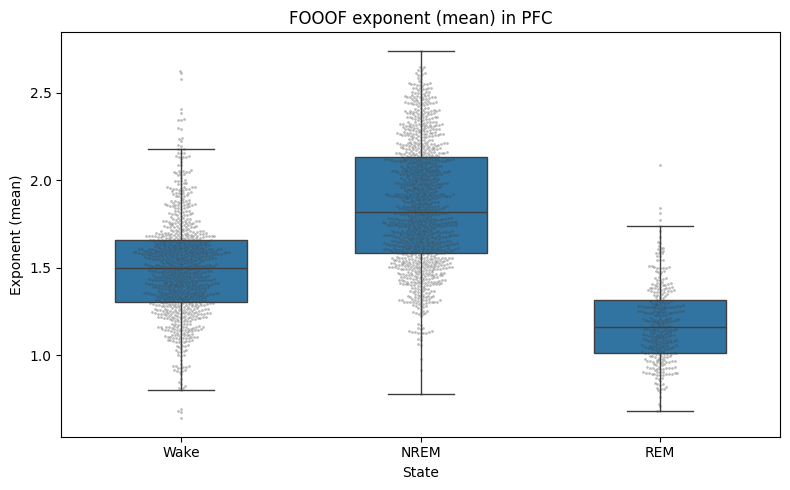

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


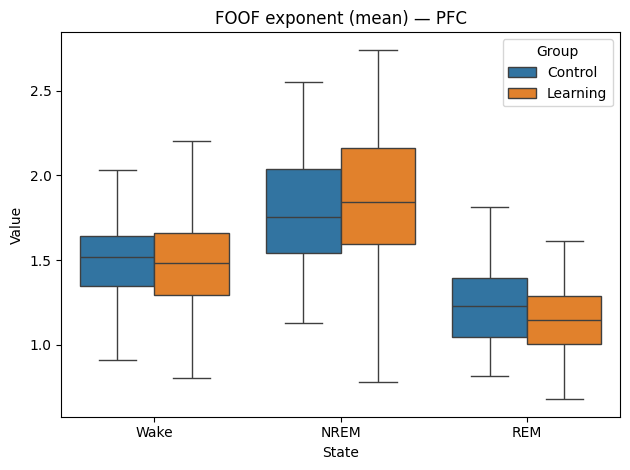

Games-Howell tests (HomeCage vs Learning)

State: Wake
         A         B   mean(A)   mean(B)      diff        se         T  \
0  Control  Learning  1.513465  1.492635  0.020829  0.019328  1.077669   

           df      pval    hedges  
0  550.688329  0.281653  0.073047  

State: NREM
         A         B   mean(A)   mean(B)      diff      se         T  \
0  Control  Learning  1.797147  1.876803 -0.079656  0.0221 -3.604293   

           df      pval    hedges  
0  626.146971  0.000338 -0.225126  

State: REM
         A         B   mean(A)   mean(B)      diff        se         T  \
0  Control  Learning  1.237335  1.158256  0.079078  0.029944  2.640907   

           df      pval    hedges  
0  135.297377  0.009241  0.354689  


In [294]:
REGION  = "PFC"      
METRIC  = "mean" 
group_type = "learning" # group type controls on what we seperate the box plot vlaues, rgs or learning 

df = collect_all_state_values(group_type, REGION, metric=METRIC)
print(df.head())
print("\nEpisode counts per state:")
print(df.groupby("State").size())
one_way_anova(df)
levene_test(df)
welch_anova(df)


order = ["Wake", "NREM", "REM"]
plt.figure(figsize=(8, 5))
sns.boxplot(x="State", y="Value",
            data=df, order=order,
            showfliers=False, width=0.55)
sns.swarmplot(x="State", y="Value",
                data=df, order=order,
                size=2, color=".25", alpha=0.35)
plt.ylabel(f"Exponent ({METRIC})")
plt.title(f"FOOOF exponent ({METRIC}) in {REGION}")
plt.tight_layout()
plt.show()

ax = sns.boxplot(x="State", y="Value", hue="Group",
                data=df, order=["Wake", "NREM", "REM"],
                showfliers=False)

ax.set_title(f"FOOF exponent (mean) — {REGION}")
plt.tight_layout()
plt.show()


df['Group'] = df['Group'].astype('category')
df['State'] = df['State'].astype('category')

print("Games-Howell tests (HomeCage vs Learning)")
for state in ["Wake", "NREM", "REM"]:
    subset = df[df["State"] == state]
    print(f"\nState: {state}")
    results = pg.pairwise_gameshowell(dv="Value", between="Group", data=subset)
    print(results)


# save the df to a csv
df.to_csv(f"./csv_outputs/{REGION}_{METRIC}_groupedby_{group_type}.csv", index=False)


      Value State    Group Region
0  1.717084  Wake  Control    PFC
1  1.376484  Wake  Control    PFC
2  1.403164  Wake  Control    PFC
3  1.732963  Wake  Control    PFC
4  1.964641  Wake  Control    PFC

Episode counts per state:
State
NREM    1128
REM      323
Wake     913
dtype: int64
One-way ANOVA (Wake, NREM, REM):  F = 703.5591, p = 0.000000

Levenes test for equal variances: W = 75.3704, p = 0.000000

Welch ANOVA:
Source  ddof1      ddof2         F         p-unc      np2
 State      2 1046.79555 868.66661 4.428511e-223 0.373427


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


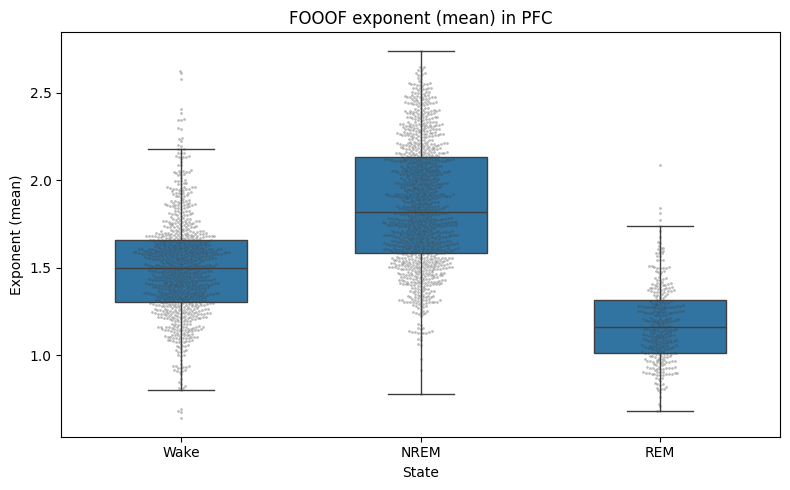

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


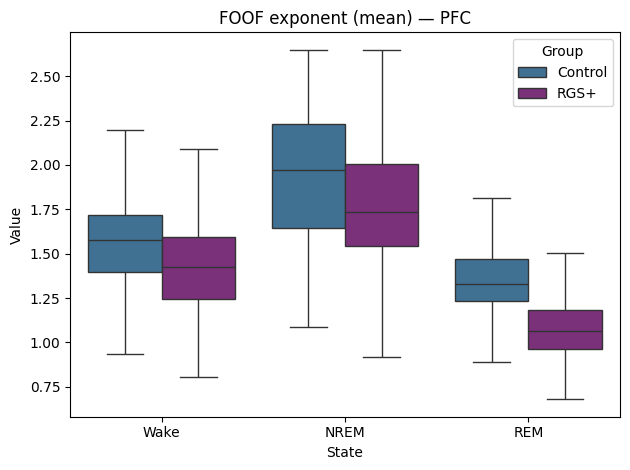

Games-Howell tests (HomeCage vs Learning)

State: Wake
         A     B   mean(A)   mean(B)      diff        se         T  \
0  Control  RGS+  1.576954  1.433528  0.143426  0.018303  7.836233   

           df          pval    hedges  
0  886.877639  4.014566e-13  0.519296  

State: NREM
         A     B   mean(A)   mean(B)      diff        se         T  \
0  Control  RGS+  1.942843  1.779418  0.163425  0.020771  7.867876   

            df          pval    hedges  
0  1071.568374  1.497691e-13  0.472194  

State: REM
         A     B   mean(A)   mean(B)      diff        se          T  \
0  Control  RGS+  1.335371  1.074603  0.260767  0.022044  11.829359   

          df  pval    hedges  
0  229.63657   0.0  1.405568  


In [295]:
REGION  = "PFC"        # or "HPC"
METRIC  = "mean"       # 'mean', 'slope', or 'std'
group_type = "rgs"

df = collect_all_state_values(group_type, REGION, metric=METRIC)
print(df.head())


print("\nEpisode counts per state:")
print(df.groupby("State").size())


one_way_anova(df)
levene_test(df)
welch_anova(df)

custom_palette = {
    "Control": "#3274A1",  
    "RGS+": "#872386"     
}

order = ["Wake", "NREM", "REM"]
plt.figure(figsize=(8, 5))
sns.boxplot(x="State", y="Value",
            data=df, order=order,
            showfliers=False, width=0.55)
sns.swarmplot(x="State", y="Value",
                data=df, order=order,
                size=2, color=".25", alpha=0.35)
plt.ylabel(f"Exponent ({METRIC})")
plt.title(f"FOOOF exponent ({METRIC}) in {REGION}")
plt.tight_layout()
plt.show()

ax = sns.boxplot(x="State", y="Value", hue="Group",
                data=df, order=["Wake", "NREM", "REM"],
                showfliers=False, palette=custom_palette)

ax.set_title(f"FOOF exponent (mean) — {REGION}", )
plt.tight_layout()
plt.show()



df['Group'] = df['Group'].astype('category')
df['State'] = df['State'].astype('category')

print("Games-Howell tests (HomeCage vs Learning)")
for state in ["Wake", "NREM", "REM"]:
    subset = df[df["State"] == state]
    print(f"\nState: {state}")
    results = pg.pairwise_gameshowell(dv="Value", between="Group", data=subset)
    print(results)

df.to_csv(f"./csv_outputs/{REGION}_{METRIC}_groupedby_{group_type}.csv", index=False)


Episode counts per state:
State
NREM    1128
REM      324
Wake     914
dtype: int64
One-way ANOVA (Wake, NREM, REM):  F = 582.3401, p = 0.000000

Levenes test for equal variances: W = 11.7907, p = 0.000008

Welch ANOVA:
Source  ddof1     ddof2          F         p-unc      np2
 State      2 849.80381 500.625605 2.189717e-144 0.330155


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


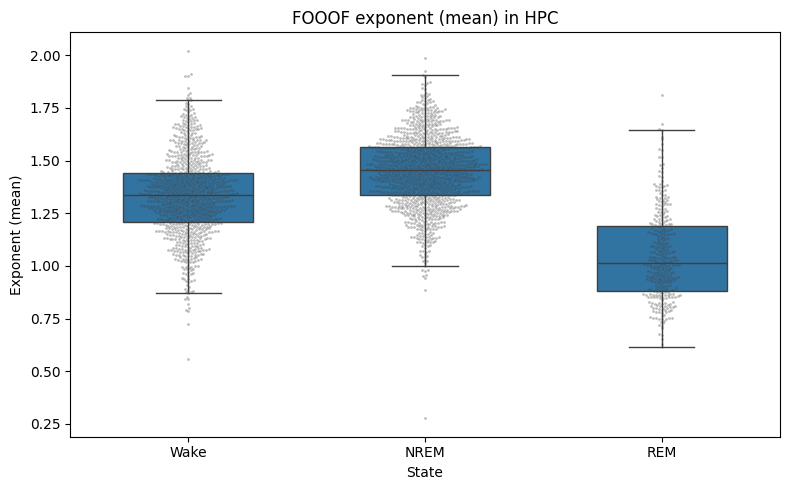

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


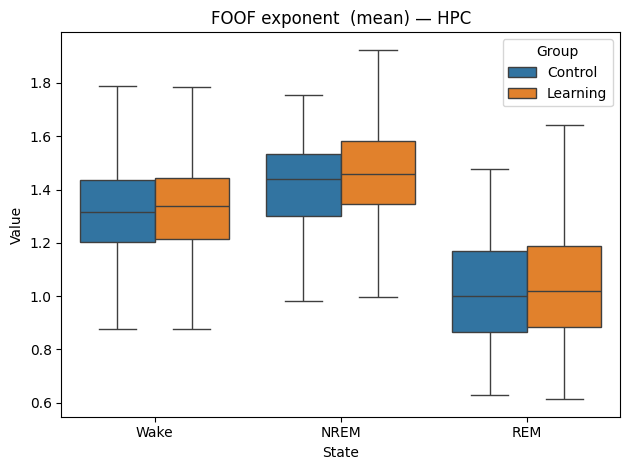

Games-Howell tests (HomeCage vs Learning)

State: Wake
         A         B   mean(A)   mean(B)      diff        se        T  \
0  Control  Learning  1.326108  1.336155 -0.010046  0.013974 -0.71892   

           df      pval    hedges  
0  483.825119  0.472537 -0.051521  

State: NREM
         A         B   mean(A)   mean(B)      diff        se         T  \
0  Control  Learning  1.416693  1.460811 -0.044118  0.010706 -4.120681   

           df      pval    hedges  
0  632.302609  0.000043 -0.256244  

State: REM
         A         B   mean(A)   mean(B)      diff        se         T  \
0  Control  Learning  1.023749  1.055588 -0.031839  0.025622 -1.242622   

           df      pval    hedges  
0  168.251783  0.215736 -0.148305  


In [305]:
REGION  = "HPC"     
METRIC  = "mean"      
group_type = "learning" 
df = collect_all_state_values(group_type, REGION, metric=METRIC)


# quick sanity-check
print("\nEpisode counts per state:")
print(df.groupby("State").size())

# stats
one_way_anova(df)
levene_test(df)
welch_anova(df)


order = ["Wake", "NREM", "REM"]
plt.figure(figsize=(8, 5))
sns.boxplot(x="State", y="Value",
            data=df, order=order,
            showfliers=False, width=0.55)
sns.swarmplot(x="State", y="Value",
                data=df, order=order,
                size=2, color=".25", alpha=0.35)
plt.ylabel(f"Exponent ({METRIC})")
plt.title(f"FOOOF exponent ({METRIC}) in {REGION}")
plt.tight_layout()
plt.show()

ax = sns.boxplot(x="State", y="Value", hue="Group",
                data=df, order=["Wake", "NREM", "REM"],
                showfliers=False)

ax.set_title(f"FOOF exponent  (mean) — {REGION}")
plt.tight_layout()
plt.show()


df['Group'] = df['Group'].astype('category')
df['State'] = df['State'].astype('category')

# Run Games-Howell pairwise test for each state
print("Games-Howell tests (HomeCage vs Learning)")
for state in ["Wake", "NREM", "REM"]:
    subset = df[df["State"] == state]
    print(f"\nState: {state}")
    results = pg.pairwise_gameshowell(dv="Value", between="Group", data=subset)
    print(results)

df.to_csv(f"./csv_outputs/{REGION}_{METRIC}_groupedby_{group_type}.csv", index=False)


      Value State    Group Region
0  1.590670  Wake  Control    HPC
1  1.430636  Wake  Control    HPC
2  1.384711  Wake  Control    HPC
3  1.567427  Wake  Control    HPC
4  1.408139  Wake  Control    HPC

Episode counts per state:
State
NREM    1128
REM      324
Wake     914
dtype: int64
One-way ANOVA (Wake, NREM, REM):  F = 582.3401, p = 0.000000

Levenes test for equal variances: W = 11.7907, p = 0.000008

Welch ANOVA:
Source  ddof1     ddof2          F         p-unc      np2
 State      2 849.80381 500.625605 2.189717e-144 0.330155


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


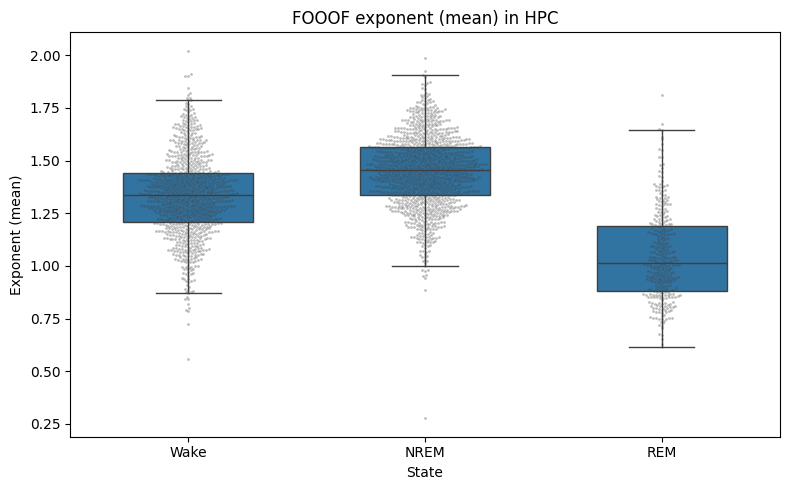

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


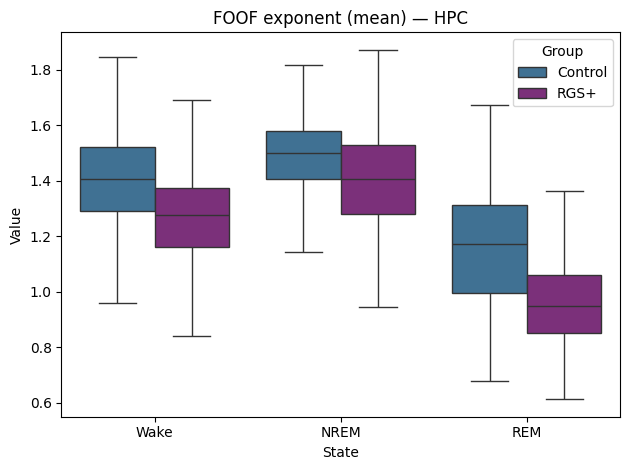

Games-Howell tests (HomeCage vs Learning)

State: Wake
         A     B   mean(A)   mean(B)     diff        se          T  \
0  Control  RGS+  1.404549  1.273939  0.13061  0.012218  10.689831   

           df          pval   hedges  
0  878.252216  2.287059e-13  0.71046  

State: NREM
         A     B   mean(A)   mean(B)      diff        se         T  \
0  Control  RGS+  1.490793  1.412466  0.078326  0.009815  7.979861   

            df          pval    hedges  
0  1064.917806  1.471046e-13  0.463996  

State: REM
         A     B   mean(A)   mean(B)      diff        se         T  \
0  Control  RGS+  1.170072  0.964593  0.205479  0.022847  8.993528   

           df  pval    hedges  
0  217.225997   0.0  1.082431  


In [297]:
REGION  = "HPC"        # or "HPC"
METRIC  = "mean"       # 'mean', 'slope', or 'std'
group_type = "rgs"

df = collect_all_state_values(group_type, REGION, metric=METRIC)
print(df.head())


print("\nEpisode counts per state:")
print(df.groupby("State").size())


one_way_anova(df)
levene_test(df)
welch_anova(df)

custom_palette = {
    "Control": "#3274A1",  
    "RGS+": "#872386"     
}

order = ["Wake", "NREM", "REM"]
plt.figure(figsize=(8, 5))
sns.boxplot(x="State", y="Value",
            data=df, order=order,
            showfliers=False, width=0.55)
sns.swarmplot(x="State", y="Value",
                data=df, order=order,
                size=2, color=".25", alpha=0.35)
plt.ylabel(f"Exponent ({METRIC})")
plt.title(f"FOOOF exponent ({METRIC}) in {REGION}")
plt.tight_layout()
plt.show()

ax = sns.boxplot(x="State", y="Value", hue="Group",
                data=df, order=["Wake", "NREM", "REM"],
                showfliers=False, palette=custom_palette)

ax.set_title(f"FOOF exponent (mean) — {REGION}", )
plt.tight_layout()
plt.show()



df['Group'] = df['Group'].astype('category')
df['State'] = df['State'].astype('category')

print("Games-Howell tests (HomeCage vs Learning)")
for state in ["Wake", "NREM", "REM"]:
    subset = df[df["State"] == state]
    print(f"\nState: {state}")
    results = pg.pairwise_gameshowell(dv="Value", between="Group", data=subset)
    print(results)

df.to_csv(f"./csv_outputs/{REGION}_{METRIC}_groupedby_{group_type}.csv", index=False)

Analyzing trajectories for: PFC


NREM→Wake:
  N trajectories: 1967
  N timepoints per trajectory: 61
  Total data points: 119987 (1967 × 61)
  Start exponent: 1.7369
  End exponent: 1.8463
  Net change: +0.1094

Wake→NREM:
  N trajectories: 2817
  N timepoints per trajectory: 61
  Total data points: 171837 (2817 × 61)
  Start exponent: 1.6807
  End exponent: 1.8792
  Net change: +0.1985

REM→Wake:
  N trajectories: 730
  N timepoints per trajectory: 61
  Total data points: 44530 (730 × 61)
  Start exponent: 1.6064
  End exponent: 1.6725
  Net change: +0.0660

NREM→REM:
  N trajectories: 245
  N timepoints per trajectory: 61
  Total data points: 14945 (245 × 61)
  Start exponent: 1.9450
  End exponent: 1.3976
  Net change: -0.5474



TOTAL SUMMARY:
  Total trajectories across all transitions: 5759
  Total data points being plotted: 351299
  Time window: -60.0s to 60.0s (61 timepoints)




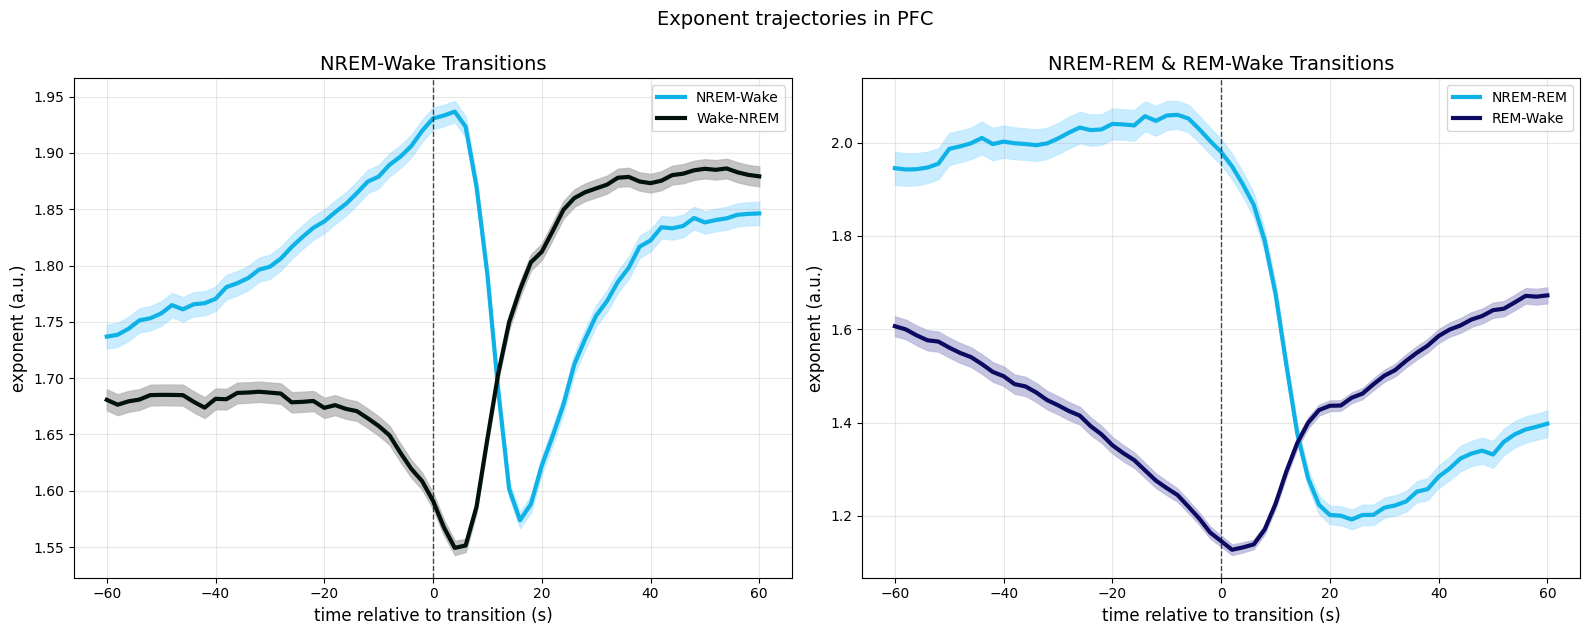

 Saved 2817 trajectories to PFC_Wake_to_NREM.csv
 Saved 245 trajectories to PFC_NREM_to_REM.csv
 Saved 730 trajectories to PFC_REM_to_Wake.csv
 Saved 1967 trajectories to PFC_NREM_to_Wake.csv
Analyzing trajectories for: HPC


NREM→Wake:
  N trajectories: 1955
  N timepoints per trajectory: 61
  Total data points: 119255 (1955 × 61)
  Start exponent: 1.3979
  End exponent: 1.4298
  Net change: +0.0319

Wake→NREM:
  N trajectories: 2804
  N timepoints per trajectory: 61
  Total data points: 171044 (2804 × 61)
  Start exponent: 1.3580
  End exponent: 1.4297
  Net change: +0.0716

REM→Wake:
  N trajectories: 726
  N timepoints per trajectory: 61
  Total data points: 44286 (726 × 61)
  Start exponent: 1.2353
  End exponent: 1.3566
  Net change: +0.1213

NREM→REM:
  N trajectories: 246
  N timepoints per trajectory: 61
  Total data points: 15006 (246 × 61)
  Start exponent: 1.4219
  End exponent: 1.1927
  Net change: -0.2292



TOTAL SUMMARY:
  Total trajectories across all transitions: 5731

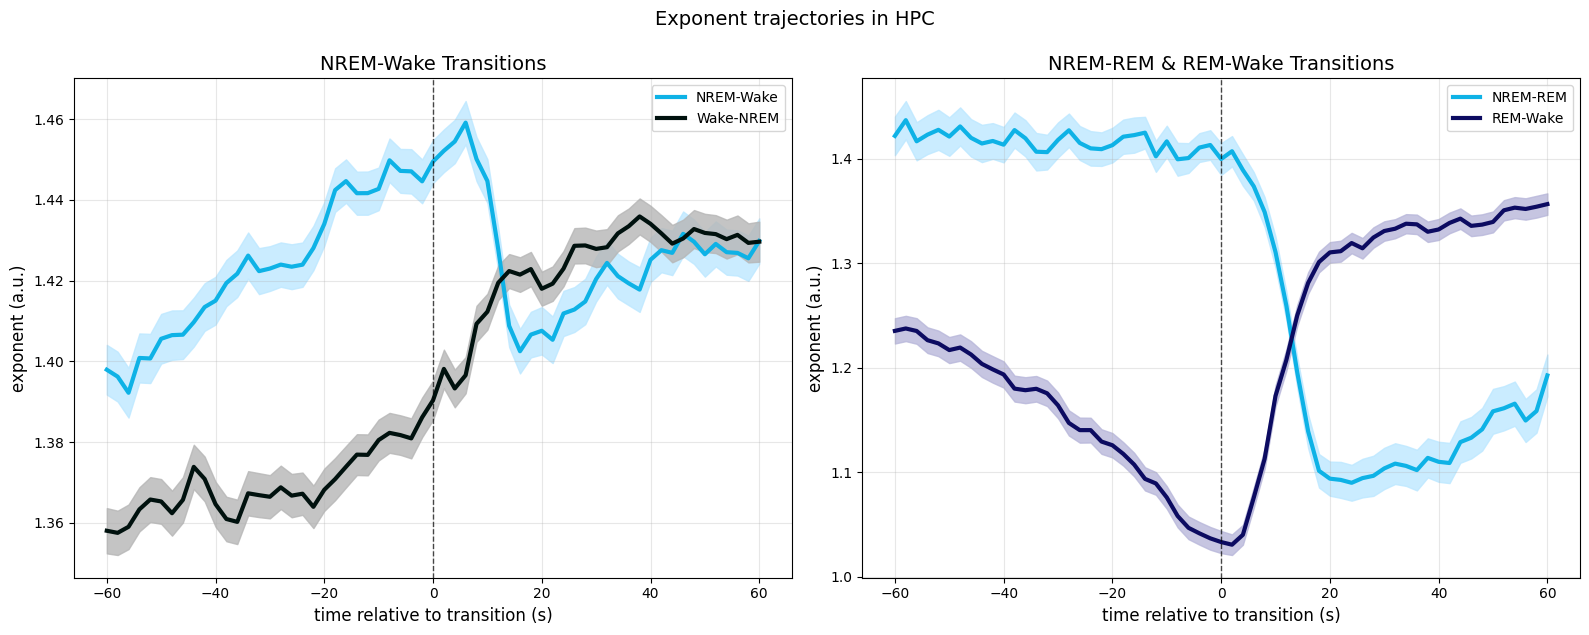

 Saved 2804 trajectories to HPC_Wake_to_NREM.csv
 Saved 246 trajectories to HPC_NREM_to_REM.csv
 Saved 726 trajectories to HPC_REM_to_Wake.csv
 Saved 1955 trajectories to HPC_NREM_to_Wake.csv


In [304]:
TRANSITIONS = USED_TRANSITIONS
MARGIN_SEC = 60  


def collect_transition_trajectories(states, exponents, times, transitions, margin_sec=MARGIN_SEC):
    if len(times) > 1:
        step_sec = np.median(np.diff(times))
    else:
        step_sec = 2.0  
    
    half_win = int(margin_sec / step_sec)
    time_rel = np.arange(-half_win, half_win + 1) * step_sec
 
    
    trajectories = {tr: [] for tr in transitions}
    
    for from_state, to_state in transitions:
        is_from = states == from_state
        is_to = states == to_state

        state_trans_idxs = np.where(is_to & np.roll(is_from, 1))[0]
        
        valid_trajectories = 0
        for state_idx in state_trans_idxs:
 
            state_time = state_idx  
        
            exp_idx = np.argmin(np.abs(times - state_time))
            time_diff = abs(times[exp_idx] - state_time)
            if time_diff > step_sec / 2: 
                continue
            
       
            start = exp_idx - half_win
            end = exp_idx + half_win + 1
            
            if start >= 0 and end <= len(exponents):
                win = exponents[start:end]
                if len(win) == len(time_rel) and not np.isnan(win).any():
                    trajectories[(from_state, to_state)].append(win)
                    valid_trajectories += 1
        
    
    return trajectories, time_rel


def collect_all_trajectories(region, base_dir="./data", foof_dir="./data/foof_results"):
    all_trajectories = {tr: [] for tr in TRANSITIONS}
    region_up = region.upper()
    
    for rat_id in ALL_RATS:
        rat_str = f"Rat{rat_id}"
        for condition in os.listdir(base_dir):
            rat_condition_dir = os.path.join(base_dir, condition, rat_str)
            if not os.path.isdir(rat_condition_dir):
                continue
                
            for trial_folder in os.listdir(rat_condition_dir):
                trial_path = os.path.join(rat_condition_dir, trial_folder)
                if not os.path.isdir(trial_path) or "Post" not in trial_folder:
                    continue
                    
                trial_match = re.search(r'Trial[_\-]?(\d+)', trial_folder, re.IGNORECASE)
                if not trial_match:
                    continue
                trial_num = int(trial_match.group(1))
                
             
                states_candidates = glob.glob(os.path.join(trial_path, '*states.mat'))
                if not states_candidates:
                    continue
                states_file = states_candidates[0] 
                foof_file = os.path.join(foof_dir, condition, f"FOOF_Transitions_{rat_str}_{region_up}_Post_trial_{trial_num}.npz")
                if not os.path.exists(foof_file):
                    continue
                    
                try:
                    states = sio.loadmat(states_file)["states"].ravel()
                    foof_data = np.load(foof_file)
                    exponents = foof_data["exponents"]
                    times = foof_data["times"]
                    
                    rat_trajectories, time_rel = collect_transition_trajectories(
                        states, exponents, times, TRANSITIONS
                    )
                    
                    for tr in TRANSITIONS:
                        all_trajectories[tr].extend(rat_trajectories[tr])
                        
                except Exception as e:
                    print(f"[ERROR] Failed to process {foof_file}: {e}")
    
    return all_trajectories, time_rel


def plot_both_transitions_combined(all_trajectories, time_rel, region):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
  
    wake_nrem_transitions = [(3, 1), (1, 3)]  # NREM->Wake, Wake->NREM
    colors1 = ['#0EB2E6', '#00110E']        # NREM->Wake (cyan), Wake->NREM (dark)
    sem_colors1 = ['#BDE8FF', '#B6B6B6']  # Light cyan, Light gray
    
    for i, (from_state, to_state) in enumerate(wake_nrem_transitions):
        trajectories = all_trajectories[(from_state, to_state)]
        
        if len(trajectories) == 0:
            print(f"Warning: No trajectories found for {STATE_MAP[from_state]}→{STATE_MAP[to_state]}")
            continue
        
        trajectories_array = np.array(trajectories)
        mean_trajectory = np.mean(trajectories_array, axis=0)
        sem_trajectory = sem(trajectories_array, axis=0)
        
        label = f"{STATE_MAP[from_state]}-{STATE_MAP[to_state]}"
        
      
        ax1.plot(time_rel, mean_trajectory, color=colors1[i], linewidth=3, label=label)
        
        ax1.fill_between(time_rel, mean_trajectory - sem_trajectory, mean_trajectory + sem_trajectory, color=sem_colors1[i], alpha=0.8)
    

    ax1.axvline(x=0, color='black', linestyle='--', alpha=0.7, linewidth=1)
    

    ax1.set_xlabel('time relative to transition (s)', fontsize=12)
    ax1.set_ylabel('exponent (a.u.)', fontsize=12)
    ax1.set_title('NREM-Wake Transitions', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    

    rem_transitions = [(3, 5), (5, 1)]  # NREM->Wake, Wake->NREM
    colors2 = ['#0EB2E6', '#0C0B61']  # NREM->Wake (cyan), Wake->NREM (dark)
    sem_colors2 = ['#BDE8FF', '#B8B7DA']  # Light cyan, Light gray
    
    for i, (from_state, to_state) in enumerate(rem_transitions):
        trajectories = all_trajectories[(from_state, to_state)]
        
        if len(trajectories) == 0:
            print(f"Warning: No trajectories found for {STATE_MAP[from_state]}→{STATE_MAP[to_state]}")
            continue
        
        trajectories_array = np.array(trajectories)
        mean_trajectory = np.mean(trajectories_array, axis=0)
        sem_trajectory = sem(trajectories_array, axis=0)
        
        label = f"{STATE_MAP[from_state]}-{STATE_MAP[to_state]}"
    
        ax2.plot(time_rel, mean_trajectory, color=colors2[i], linewidth=3, label=label)
        ax2.fill_between(time_rel, 
                        mean_trajectory - sem_trajectory,
                        mean_trajectory + sem_trajectory,
                        color=sem_colors2[i], alpha=0.8)
    
    # vertical line at transition point
    ax2.axvline(x=0, color='black', linestyle='--', alpha=0.7, linewidth=1)
    
    # formatting for plot 2
    ax2.set_xlabel('time relative to transition (s)', fontsize=12)
    ax2.set_ylabel('exponent (a.u.)', fontsize=12)
    ax2.set_title('NREM-REM & REM-Wake Transitions', fontsize=14)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle(f"Exponent trajectories in {region}", fontsize=14, y=1.05)
    plt.show()


def print_trajectory_stats(all_trajectories, time_rel):
    total_trajectories = 0
    total_data_points = 0
    print("\n")
    for from_state, to_state in TRANSITIONS:
        trajectories = all_trajectories[(from_state, to_state)]
        n_trajectories = len(trajectories)
        total_trajectories += n_trajectories
        
        if n_trajectories > 0:
            trajectories_array = np.array(trajectories)
            n_timepoints = trajectories_array.shape[1]
            n_data_points = n_trajectories * n_timepoints
            total_data_points += n_data_points
            
            mean_start = np.mean(trajectories_array[:, 0])  # First timepoint
            mean_end = np.mean(trajectories_array[:, -1])   # Last timepoint
            change = mean_end - mean_start
            
            print(f"{STATE_MAP[from_state]}→{STATE_MAP[to_state]}:")
            print(f"  N trajectories: {n_trajectories}")
            print(f"  N timepoints per trajectory: {n_timepoints}")
            print(f"  Total data points: {n_data_points} ({n_trajectories} × {n_timepoints})")
            print(f"  Start exponent: {mean_start:.4f}")
            print(f"  End exponent: {mean_end:.4f}")
            print(f"  Net change: {change:+.4f}")
            print()
        else:
            print(f"{STATE_MAP[from_state]}→{STATE_MAP[to_state]}:")
            print(f"  N trajectories: 0 (NO DATA)")
            print()
    
    print("\n")
    print(f"TOTAL SUMMARY:")
    print(f"  Total trajectories across all transitions: {total_trajectories}")
    print(f"  Total data points being plotted: {total_data_points}")
    print(f"  Time window: {time_rel[0]:.1f}s to {time_rel[-1]:.1f}s ({len(time_rel)} timepoints)")
    print("\n")



def export_trajectories_per_transition(all_trajectories, time_rel, region, output_dir="./csv_outputs"):
    os.makedirs(output_dir, exist_ok=True)

    transition_labels = {
        (1, 3): "Wake_to_NREM",
        (3, 5): "NREM_to_REM",
        (5, 1): "REM_to_Wake",
        (3, 1): "NREM_to_Wake",
    }

    for tr, label in transition_labels.items():
        trajectories = all_trajectories[tr]
        if not trajectories:
            print(f"No data for transition: {label}")
            continue

        df_list = []
        for i, traj in enumerate(trajectories):
            df = pd.DataFrame({
                "time": time_rel,
                "value": traj,
                "trajectory_id": i
            })
            df_list.append(df)

        full_df = pd.concat(df_list, ignore_index=True)
        filename = f"{region}_{label}.csv"
        full_path = os.path.join(output_dir, filename)
        full_df.to_csv(full_path, index=False)
        print(f" Saved {len(trajectories)} trajectories to {filename}")



def main(region="PFC"):
    print(f"Analyzing trajectories for: {region}")
    print("Collecting trajectories from all rats and conditions...")
    

    all_trajectories, time_rel = collect_all_trajectories(region)
    print_trajectory_stats(all_trajectories, time_rel)
    plot_both_transitions_combined(all_trajectories, time_rel, region)

    return all_trajectories, time_rel


all_trajectories, time_rel = main("PFC")
export_trajectories_per_transition(all_trajectories, time_rel, region="PFC")

all_trajectories_hpc, time_rel_hpc = main("HPC")
export_trajectories_per_transition(all_trajectories_hpc, time_rel_hpc, region="HPC")